# Making imports

In [1]:
import sys
import json
import string
import itertools
import numpy as np
import pandas as pd

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder

import plotly
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

sys.path.append('../utils')
import sncf_utils as f
from sncf_connection import SNCF

sns.set()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thibaud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading data

In [2]:
file_name = 'regularite-mensuelle-tgv-aqst.csv'
file_path = f.DATA_PATH + 'csv/' + file_name
df = pd.read_csv(file_path, sep=';')
df.head()

,Année,Mois,Service,Gare de départ,Gare d'arrivée,Durée moyenne du trajet (min),Nombre de circulations prévues,Nombre de trains annulés,Commentaire (facultatif) annulations,Nombre de trains en retard au départ,...,Retard moyen trains en retard > 15min,Nombre trains en retard > 30min,Nombre trains en retard > 60min,Période,Retard pour causes externes,Retard à cause infrastructure ferroviaire,Retard à cause gestion trafic,Retard à cause matériel roulant,Retard à cause gestion en gare et réutilisation de matériel,Retard à cause prise en compte voyageurs
0,2018,3.0,NaN,STRASBOURG,PARIS EST,112.402439,505.0,13.0,NaN,250.0,...,5.754031,26.0,6.0,2018-03,37.662338,15.584416,19.480519,16.883117,6.493506,3.896104
1,2018,3.0,NaN,PARIS NORD,DUNKERQUE,120.996310,285.0,14.0,NaN,65.0,...,6.697417,19.0,7.0,2018-03,30.769231,17.948718,15.384615,33.333333,2.564103,0.000000
2,2018,3.0,NaN,LYON PART DIEU,PARIS LYON,120.549770,664.0,11.0,NaN,404.0,...,2.210031,12.0,1.0,2018-03,39.215686,5.882353,13.725490,23.529412,15.686275,1.960784
3,2018,3.0,NaN,PARIS LYON,GENEVE,194.005000,203.0,3.0,NaN,26.0,...,0.982500,4.0,0.0,2018-03,25.000000,15.000000,35.000000,10.000000,15.000000,0.000000
4,2018,8.0,NaN,LILLE,MARSEILLE ST CHARLES,309.389535,173.0,1.0,NaN,46.0,...,10.442151,13.0,6.0,2018-08,25.925926,7.407407,18.518519,29.629630,11.111111,7.407407


# Preparing data

In [3]:
word = df["Commentaire (facultatif) retards à l'arrivée"]
word.dropna().head()

4     Pendant les deux premières semaines d’août, le...
5     •bruit anormal sous caisse sur le OUIGO 7601 e...
8     •heurt d’une personne par le TER 17471 à Antib...
10    Ce mois-ci, cette destination a été touchée pa...
21    Ce mois-ci, l'OD a été touchée par les inciden...
Name: Commentaire (facultatif) retards à l'arrivée, dtype: object

In [4]:
# Preparing transformations for preprocessing function
caracters_to_remove = list(string.punctuation)
transformation_car_dict = {initial:" " for initial in caracters_to_remove}

with_accent = ['é', 'è', 'ê', 'à', 'ù', 'ç', 'ô', 'î']
without_accent = ['e', 'e', 'e', 'a', 'u', 'c', 'o', 'i']
transformation_accent_dict = {before:after for before, after in zip(with_accent, without_accent)}

stopW = stopwords.words('english')


In [5]:
# Preprocessing function to apply to the content column
def preprocessing(review):
  
    # Tokenization
    tokens = word_tokenize(review)
    
    # Deleting words with  only one caracter
    tokens = [token for token in tokens if len(token)>2]
    
    # stopwords + lowercase
    tokens = [token.lower() for token in tokens if token.lower() not in stopW]   
    
    # Removing accents
    tokens = [token.translate(str.maketrans(transformation_accent_dict)) for token in tokens]
    
    # Deleting specific caracters
    tokens = [token.translate(str.maketrans(transformation_car_dict)) for token in tokens]
    
    
    return tokens
  

# Creating a new column swith tokenized reviews
tokenized = word.dropna().apply(preprocessing)

# Creating wordcloud

In [20]:
# Preparing tokens for wordcloud
merged = list(itertools.chain(*tokenized.tolist()))
df_token = pd.Series(merged)
wordcloud_dict = df_token.value_counts().head(500).to_dict()

#read mask (just for fun)
hotel_mask = np.array(Image.open("train.svg"))

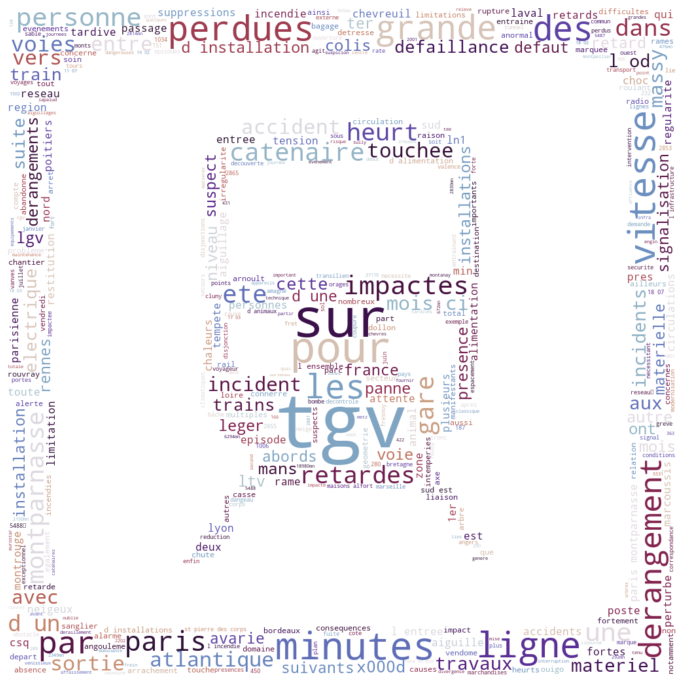

In [21]:
# Make wordcould
wordcloud = WordCloud(height=600, width=800, background_color="white", colormap='twilight_shifted', max_words=400, mask=hotel_mask)
wordcloud.generate_from_frequencies(frequencies=wordcloud_dict)

# Plot it
plt.figure(figsize=(12,16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()